In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import numpy as np
import torch
from transformers import CLIPProcessor, CLIPModel
import cv2
import os

In [13]:
def objectDetection(img_path:str, model) -> list:
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    image_name = os.path.basename(img_path)
    image_name = image_name.split('.')[0]

    result = model(image)
    result.crop(save_dir=os.path.join("YOLO", image_name))
    detectedObjects = result.render()[0]
    path = os.path.join("YOLO", image_name, 'crops', '**', '*.jpg')

    listOfObjects = []
    for filename in glob(path):
        obj = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
        listOfObjects.append(obj)     

    return listOfObjects, detectedObjects

In [14]:
def similarity_top(similarity_list:list, listOfObjects:list, N) -> tuple():
    results = zip(range(len(similarity_list)), similarity_list)
    results = sorted(results, key=lambda x: x[1], reverse=True)
    images = []
    scores=[]
    for index, score in results[:N]:
        scores.append(score)
        images.append(listOfObjects[index])

    return scores, images


def findObjects(listOfObjects:list, query:list, model, preprocess, device:str, N) -> tuple():
    # objects = torch.stack([preprocess(Image.fromarray(im)) for im in listOfObjects]).to(device)

    # with torch.no_grad():
    #     image_features = model.encode_image(objects)
    #     image_features /= image_features.norm(dim=-1, keepdim=True)

    #     text_features = model.encode_text(clip.tokenize(query).to(device))
    #     text_features /= text_features.norm(dim=-1, keepdim=True)

    # similarity = (text_features.cpu().numpy() @ image_features.cpu().numpy().T) * 100
    # similarity = similarity[0]
    # scores, images = similarity_top(similarity, listOfObjects, N=N)     

    # return scores, images

    similarity=[]

    for i in listOfObjects:
        objects = preprocess(text=query, images=Image.fromarray(i), return_tensors="pt", padding=True)

        outputs = model(**objects)
        logits_per_image = outputs.logits_per_image
        logits_per_image = logits_per_image[0][0].item()
        similarity.append(logits_per_image)

    scores, images = similarity_top(similarity, listOfObjects, N=N)

    return scores, images

In [15]:
def plotResults(scores:list, images:list, n):
    plt.figure(figsize=(20,5))
    for index, img in enumerate(images):
        plt.subplot(1,n, index+1)
        plt.imshow(img)
        plt.title(scores[index])
        plt.axis('off')
    plt.show()

In [16]:
OBJDETECTIONMODEL = 'yolov5x6'
OBJDETECTIONREPO = 'ultralytics/yolov5'
DEVICE = 'cpu'
N = 5

In [17]:
objectDetectorModel = torch.hub.load(OBJDETECTIONREPO, OBJDETECTIONMODEL)
objectFinderModel = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
preProcess = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Using cache found in C:\Users\prath/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-2-8 Python-3.9.18 torch-2.1.2+cpu CPU

Fusing layers... 
YOLOv5x6 summary: 574 layers, 140730220 parameters, 0 gradients, 209.6 GFLOPs
Adding AutoShape... 


In [18]:
def pipeline(image, query):
    listOfObjects, detectedObjects = objectDetection(image, objectDetectorModel)
    scores, images = findObjects(listOfObjects, query, objectFinderModel, preProcess, DEVICE, N)
    plt.figure(figsize=(20,5))
    plt.axis('off')
    plt.imshow(detectedObjects)
    plotResults(scores, images, N)

Saved 1 image to YOLO\34
Saved results to YOLO\34



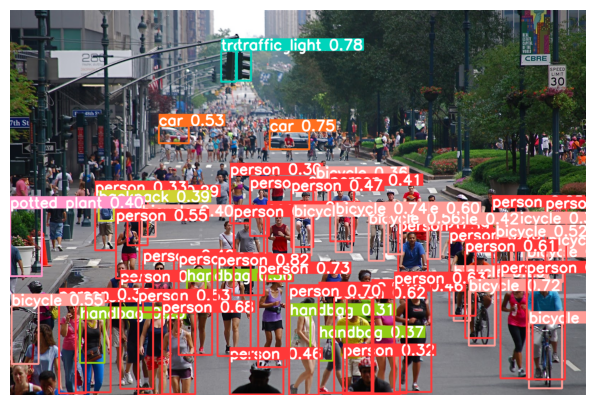

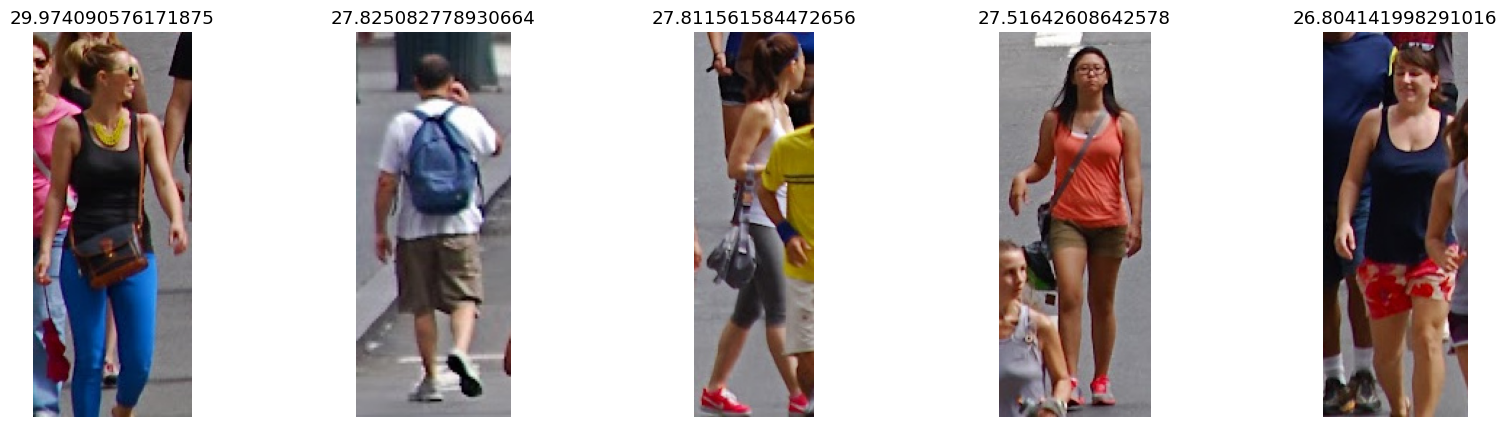

In [20]:
pipeline("3.jpg", ['woman with blue pants','not woman with blue pants'])

Saved 1 image to YOLO\35
Saved results to YOLO\35



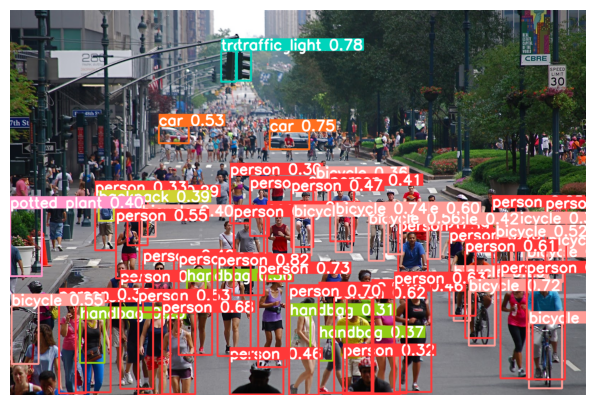

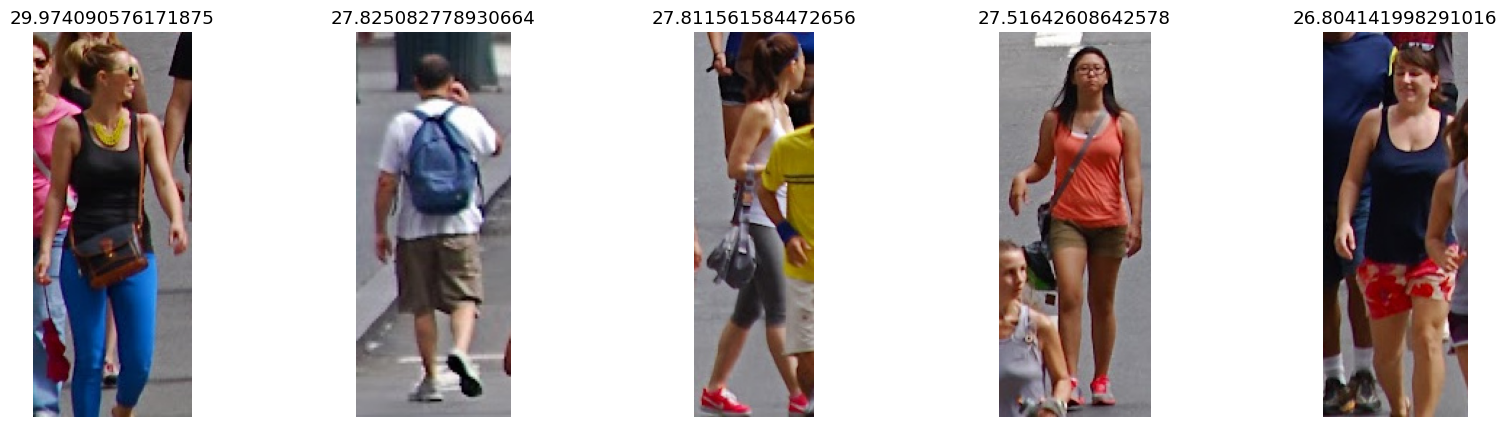

In [21]:
pipeline("3.jpg", ['woman with blue pants','dog'])

Saved 1 image to YOLO\36
Saved results to YOLO\36



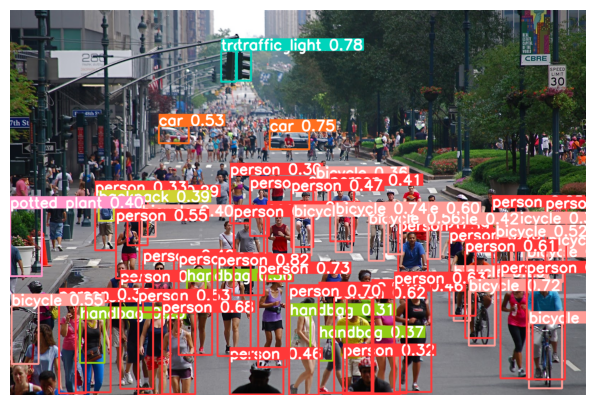

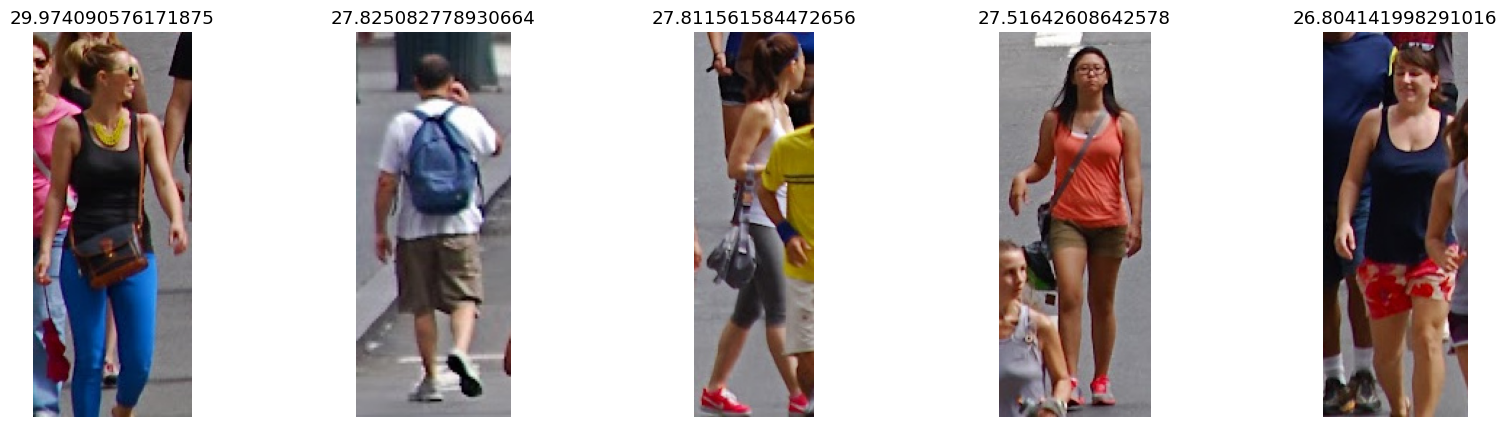

In [22]:
pipeline("3.jpg", ['woman with blue pants','yellow pants'])